## Importing the relevant libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, gc, joblib, re
warnings.filterwarnings('ignore')
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, PrecisionRecallDisplay, RocCurveDisplay
from feature_engine.outliers import Winsorizer
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, DropDuplicateFeatures
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassPredictionError


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Loading the dataset

In [3]:
df = pd.read_csv('data.csv')
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


## Data Exploration

In [4]:
df.shape

(6819, 96)

In [5]:
df.isnull().sum()

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
# Removing the columns with zero variance
df.drop(df.columns[df.nunique() == 1][0],axis=1,inplace=True)

In [8]:
df.columns = df.columns.str.replace(' ','')

In [9]:
df.rename({'Liability-AssetsFlag': 'LiabilityAssetsFlag'},axis=1,inplace=True)
df.rename({'WorkingCapital/Equity': 'Equity'},axis=1,inplace=True)
df.rename({'Interest-bearingdebtinterestrate': 'DebtInterestRate'},axis=1,inplace=True)
df.rename({'ROA(C)beforeinterestanddepreciationbeforeinterest': 'ROA'},axis=1,inplace=True)
df.rename({'Cash/TotalAssets': 'TotalAsset'},axis=1,inplace=True)
df.rename({'Non-industryincomeandexpenditure/revenue': 'Revenue'},axis=1,inplace=True)
df.rename({'NetValuePerShare(B)': 'NetValuePerShare'},axis=1,inplace=True)
df.rename({'Totaldebt/Totalnetworth': 'TotalDebt'},axis=1,inplace=True)

## Feature Engineering

### Feature Splitting

In [10]:
X = df.drop('Bankrupt?',axis=1)
y = df['Bankrupt?']

### Data Preprocessing

In [11]:
pipeline = Pipeline(steps=[
    ('constant',DropConstantFeatures()),
    ('correlated',DropCorrelatedFeatures()),
    ('duplicate',DropDuplicateFeatures())
])

X = pipeline.fit_transform(X)
X.shape

(6819, 69)

### Outlier Removal

In [12]:
def remove_outliers(data,col):
    winsorizer = Winsorizer(capping_method='iqr',tail='both',fold=1.5)
    data[col] = winsorizer.fit_transform(data[[col]])
    return data[col]

In [13]:
for col in X.drop('LiabilityAssetsFlag',axis=1).columns:
    X[col] = remove_outliers(X,col)

### Balancing out imbalanced target labels

In [14]:
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE
import pandas as pd
from sklearn.datasets import make_classification
smote = BorderlineSMOTE()
X, y = smote.fit_resample(X, y)

In [15]:
print("Final dimensions of target label classes:", Counter(y))

Final dimensions of target label classes: Counter({1: 6599, 0: 6599})


In [16]:
X.shape

(13198, 69)

### Performing train-test-split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,shuffle=True,random_state=58)
print(y_test)

3141     0
10279    1
1586     0
11535    1
9227     1
        ..
7355     1
5692     0
9433     1
544      0
9233     1
Name: Bankrupt?, Length: 3960, dtype: int64


### Feature Selection

In [18]:
final_selected_features = ['Equity',
                           'PersistentEPSintheLastFourSeasons',
                           'Borrowingdependency',
                           'NetValueGrowthRate',
                           'DebtInterestRate',
                           'ROA',
                           'TotalAsset',
                           'Revenue',
                           'NetValuePerShare',
                           'TotalDebt']

final_X_train = X_train[final_selected_features]
final_X_test = X_test[final_selected_features]

In [19]:
gc.collect()

0

### Feature Scaling

In [20]:
scaler = StandardScaler()
features = final_X_train.columns
final_X_train = scaler.fit_transform(final_X_train)
final_X_train = pd.DataFrame(final_X_train,columns=features)
final_X_test = scaler.transform(final_X_test)
final_X_test = pd.DataFrame(final_X_test,columns=features)
final_X_train.head()

,Equity,PersistentEPSintheLastFourSeasons,Borrowingdependency,NetValueGrowthRate,DebtInterestRate,ROA,TotalAsset,Revenue,NetValuePerShare,TotalDebt
0,-0.562785,0.313723,-0.543937,0.161754,0.332953,0.201148,-0.842687,2.308123,0.357017,-0.949863
1,-0.359097,-1.288804,1.018171,-1.358470,0.034586,-1.476888,-0.271694,-1.255696,-0.881979,0.478944
2,1.080359,0.580719,-0.204379,-0.157916,-0.292930,0.454780,-0.292218,0.464958,0.316799,-0.660306
3,-0.325068,0.215563,-0.826057,0.134251,-0.043369,0.057453,0.432608,0.680725,1.430640,-1.238957
4,0.279195,-0.404810,-1.334809,-0.513458,-0.368194,-1.099903,0.289365,0.927578,-0.513772,-1.739032


In [29]:
final_X_test.head()
print(final_X_test)
print(y_test)

        Equity  PersistentEPSintheLastFourSeasons  Borrowingdependency  \
0     0.671651                           1.495572            -1.225972   
1    -1.649033                          -0.347144             0.208523   
2     0.723952                           0.309797            -0.490589   
3     0.192749                          -0.720124            -0.079863   
4    -1.259481                          -0.955225            -0.161856   
...        ...                                ...                  ...   
3955 -1.695482                          -1.356068             1.404970   
3956  1.092747                           2.640121            -0.984154   
3957 -1.714940                          -0.931684             1.347778   
3958 -0.903952                           0.140961            -0.519794   
3959  1.182661                          -1.364817             0.281484   

      NetValueGrowthRate  DebtInterestRate       ROA  TotalAsset   Revenue  \
0               0.487004         

## Model Training & Evaluation

In [22]:
models = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

In [23]:

def train_and_evaluate_model(model):
    model.fit(final_X_train,y_train)
    y_pred = model.predict(final_X_test)
    print("Classification Report:")
    print(classification_report(y_test,y_pred))
    print('-'*50)
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
    PrecisionRecallDisplay.from_predictions(y_test,y_pred)
    RocCurveDisplay.from_predictions(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,average='macro')
    recall = recall_score(y_test,y_pred,average='macro')
    f1 = f1_score(y_test,y_pred,average='macro')
    roc_auc = roc_auc_score(y_test,y_pred,average='macro')
    
    if re.search('catboost',str(model)) == None:
        visualizer = ClassPredictionError(model)
        visualizer.score(final_X_test,y_test)
        visualizer.show()
        del visualizer
        
    accuracy_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    models.append(model)
    del acc, precision, recall, f1, roc_auc
    gc.collect()

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1999
           1       0.97      0.99      0.98      1961

    accuracy                           0.98      3960
   macro avg       0.98      0.98      0.98      3960
weighted avg       0.98      0.98      0.98      3960

--------------------------------------------------


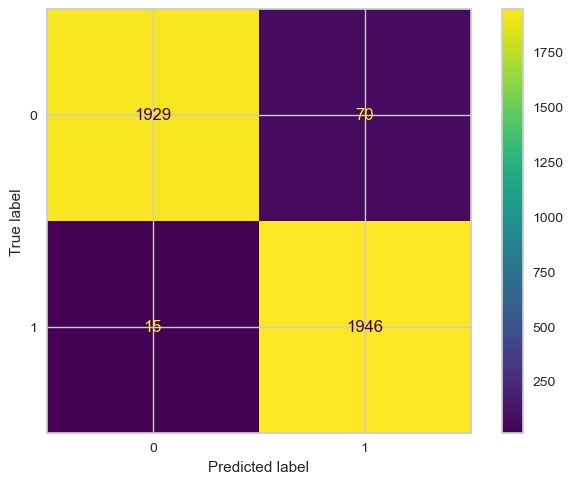

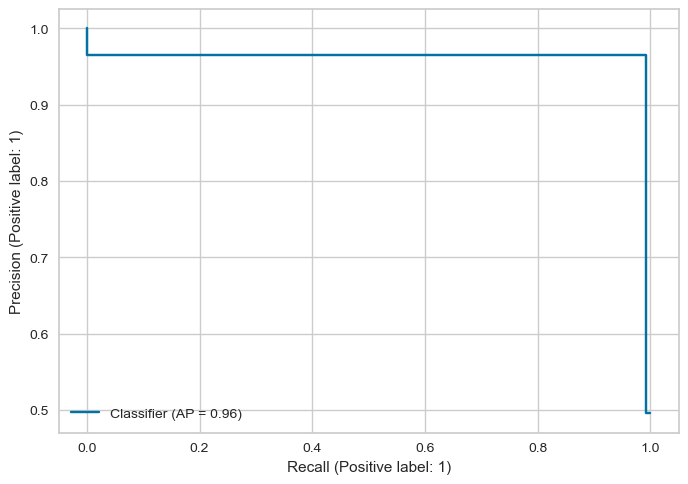

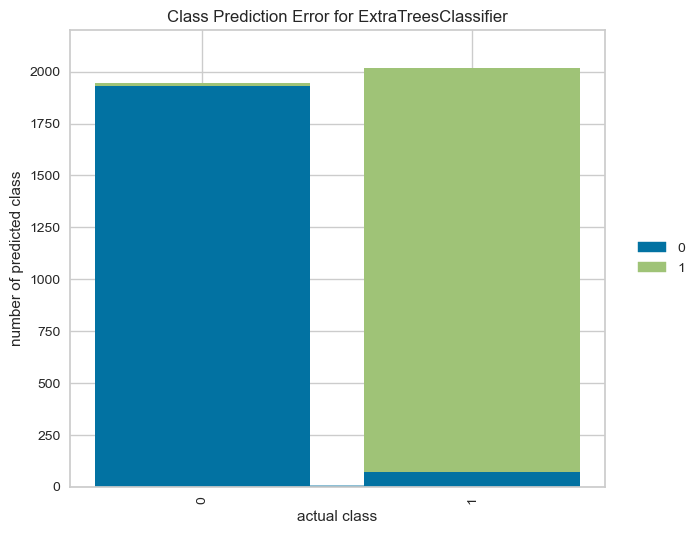

In [24]:
train_and_evaluate_model(ExtraTreesClassifier())

Among all the baseline models, the ExtraTree Classifier is the best performing model which outperforms all other models by achieving a remarkable accuracy of almost 98% on the test set.

## Saving the best performing model for deployment into production

In [25]:
model = ExtraTreesClassifier()
model.fit(final_X_train,y_train)

ExtraTreesClassifier()

In [26]:
accuracy_score(y_test, ExtraTreesClassifier().fit(final_X_train,y_train).predict(final_X_test))

0.9785353535353535

In [27]:
import pickle
pickle.dump(model, open('FinalModel.pkl', 'wb') )